*Source*
https://www.kaggle.com/pavlofesenko/selling-life-insurance-to-titanic-passengers?scriptVersionId=9284633

# Github

https://github.com/christinewinter/ml-decision-tree-titanic

# What is the goal?

Predict if a passenger would survive on Titanic 

In [1]:
# Silencing warnings from scikit-learn
import warnings
warnings.filterwarnings("ignore")

# Importing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection, linear_model, metrics
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Import Titanic data

### Training data that we use for training our model
For this data we know if passengers survived or not. 

In [2]:
data = pd.read_csv("../data/train.csv", index_col=0)

# Understand the data

In [3]:
data.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### Data definition

https://www.kaggle.com/c/titanic/data

|Variable|Definition|Key|
|:---:|:----------:|:---:|
|survival 	|Survival |0 = No, 1 = Yes|
|pclass 	|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex 	    |Sex 	||
|Age 	    |Age in years||
|sibsp  	|    # of siblings / spouses aboard the Titanic ||
|parch 	    |# of parents / children aboard the Titanic 	||
|ticket 	|Ticket number 	||
|fare 	    |Passenger fare ||
|cabin 	    |Cabin number 	||
|embarked 	|Port of Embarkation 	|C = Cherbourg, Q = Queenstown, S = Southampton|

**Variable Notes**

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

### Types in python and basic information about the occurence of data 


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Almost all columns have data, just column "Cabin" does not contain that much --> candidate to remove 

### Age - continuous

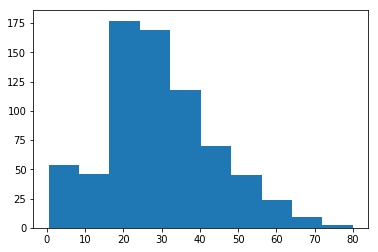

In [5]:
# Age distribution on board
data['Age'].hist(grid=False)

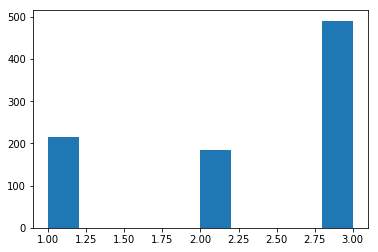

In [6]:
data['Pclass'].hist(grid=False)

### Gender - categorical

In [7]:
# Gender distribution on board
print("Male passengers: %s" %data[data["Sex"]=='male'].count()["Sex"])
print("Female passengers: %s" %data[data["Sex"]=='female'].count()["Sex"])

Male passengers: 577
Female passengers: 314


### Age distribution by gender 

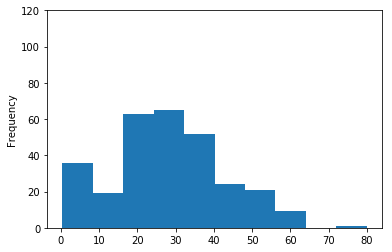

In [8]:
data['Age'].where(data['Survived']==1).plot.hist(ylim=(0,120))

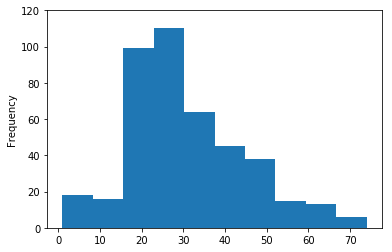

In [9]:
data['Age'].where(data['Survived']==0).plot.hist(ylim=(0,120))

Looks like more persons under 10 survived, but not so many between 18 and 30. So age could be a valuable feature to take into our model.

That is interesting. Woman and children were treated differently during emergency disembarktion. So we could expect differnt survival rates.

### Survival rate - binary 

In [10]:
print("Survival rate male passengers: %s" % data[data["Sex"]=='male']['Survived'].mean())
print("Survival rate female passengers: %s" % data[data["Sex"]=='female']['Survived'].mean())

Survival rate male passengers: 0.18890814558058924
Survival rate female passengers: 0.7420382165605095


In [11]:
# What is the rough procentage of passengers survived? Since it is 0 (died) and 1 (survived) the average is the survival rate. 
data['Survived'].mean()

0.3838383838383838

### Pclass - categorical

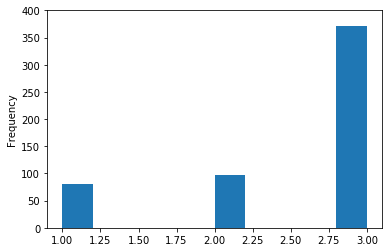

In [12]:
data['Pclass'].where(data['Survived']==0).plot.hist(ylim=(0,400))

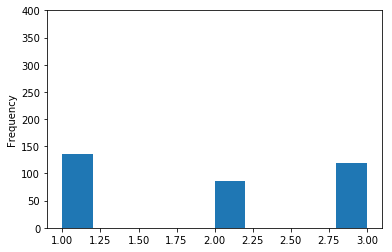

In [13]:
data['Pclass'].where(data['Survived']==1).plot.hist(ylim=(0,400))

For the survivers it looks quite even between the classes, but for the persons that died there is definitely a majority of 3rd class.

# Feature selection

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Next we select features that might be interesting. --> This process usually takes long with real data. 

Cabin information only available for a third of passengers --> drop
Name is different for all passangers --> drop
Embarked --> drop
Ticket is a number an unique --> drop

An intuitive selection after looking at the data:
* Pclass
* Sex
* Age
* Fare
* Parch
* SibSp


In [103]:
# Throw all columns that are not interesitng
X = data.drop(['Embarked', 'Name', 'Ticket', 'Cabin'], axis=1)
X.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,,
1,0,3,male,22.0,1,0,7.2500
2,1,1,female,38.0,1,0,71.2833
3,1,3,female,26.0,0,0,7.9250
4,1,1,female,35.0,1,0,53.1000
5,0,3,male,35.0,0,0,8.0500


### Transform categorical data and clean up missing rows

In [120]:
X_sex = pd.get_dummies(X['Sex'])
X_pclass = pd.get_dummies(X['Pclass'], prefix="Pclass")

X_pp = pd.concat([X, X_sex, X_pclass], axis=1)

X_pp = X_pp.drop(['Sex', 'Pclass','male'], axis=1)
X_pp.fillna(method='ffill',inplace=True)
X_pp.head()

,Survived,Age,SibSp,Parch,Fare,female,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,
1,0,22.0,1,0,7.2500,0,0,0,1
2,1,38.0,1,0,71.2833,1,1,0,0
3,1,26.0,0,0,7.9250,1,0,0,1
4,1,35.0,1,0,53.1000,1,1,0,0
5,0,35.0,0,0,8.0500,0,0,0,1


## Separate target from features

In [121]:
y = X_pp['Survived']
X_pp = X_pp.drop(['Survived'], axis=1)

In [122]:
y.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

In [123]:
X_pp.head()

,Age,SibSp,Parch,Fare,female,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,
1,22.0,1,0,7.2500,0,0,0,1
2,38.0,1,0,71.2833,1,1,0,0
3,26.0,0,0,7.9250,1,0,0,1
4,35.0,1,0,53.1000,1,1,0,0
5,35.0,0,0,8.0500,0,0,0,1


We select the target value that we want to learn to predict. In this case it's "Survived".

# Train the model

In [124]:
# Splitting the final dataset into training and testing datasets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_pp, y, random_state=0)

In [125]:
X_train.count()

Age         668
SibSp       668
Parch       668
Fare        668
female      668
Pclass_1    668
Pclass_2    668
Pclass_3    668
dtype: int64

In [126]:
X_test.count()

Age         223
SibSp       223
Parch       223
Fare        223
female      223
Pclass_1    223
Pclass_2    223
Pclass_3    223
dtype: int64

In [127]:
# Define a decision tree https://scikit-learn.org/stable/modules/tree.html
model = DecisionTreeClassifier(
    min_samples_split=15, 
    max_leaf_nodes=8, 
    random_state=0,
) # Random state is fixed for reproducibility

In [128]:
# Fit the model with training data 
model.fit(X_train, y_train.tolist())

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=8, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=15, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

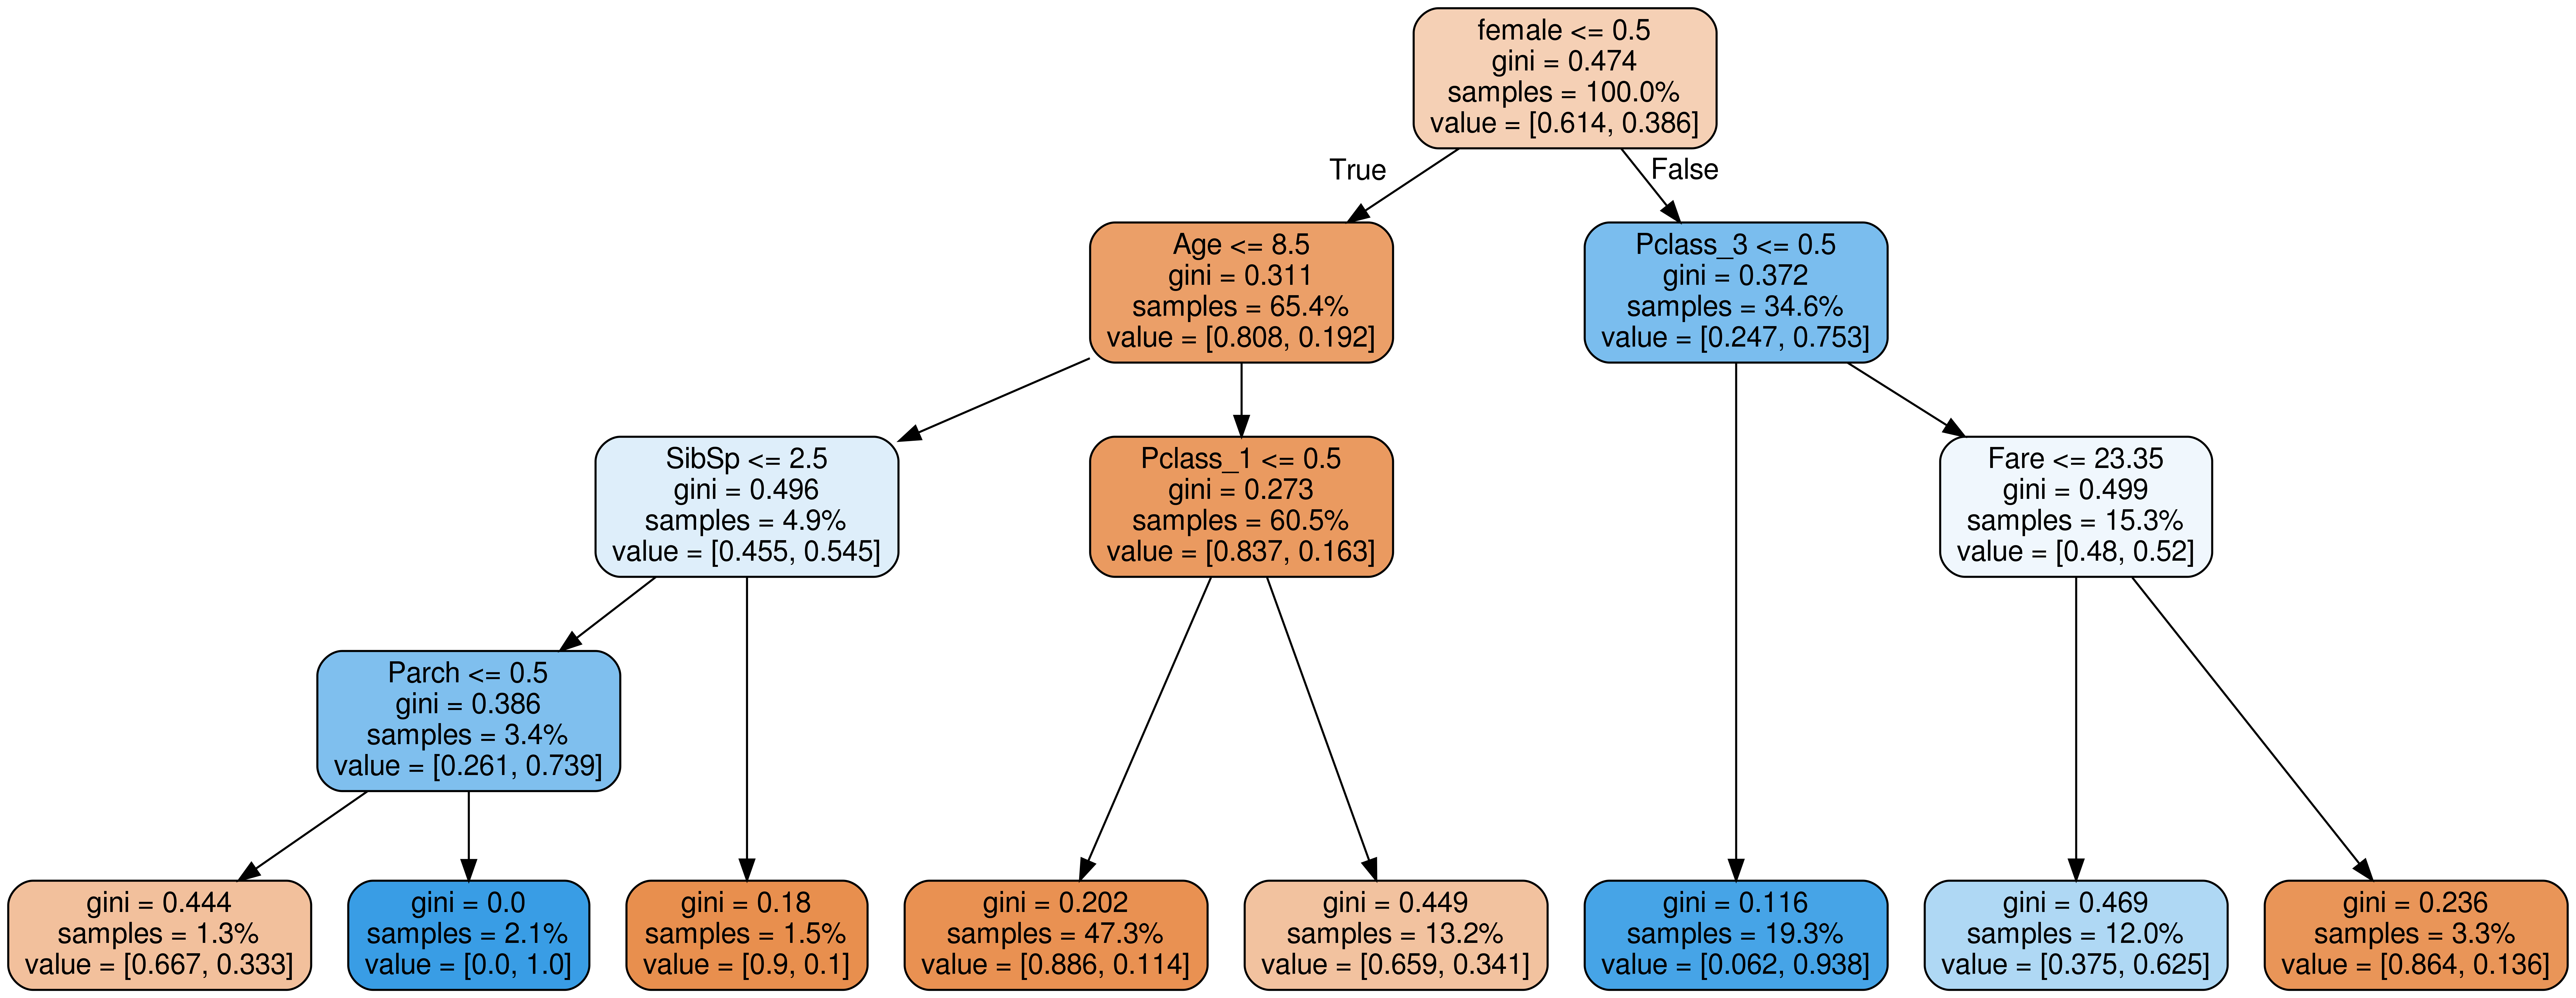

In [129]:
from sklearn.tree import export_graphviz

export_graphviz(model, out_file='decision_tree_titanic.dot',
                label='all',
                class_names=None,
                feature_names=X_train.columns,
                leaves_parallel=True,
                proportion= True, 
                rounded = True, 
                filled = True, 
                impurity=True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
# need to run "dot -Tpng decision_tree_titanic.dot -o decision_tree_titanic.png" to convert dot to png
call(['dot', '-Tpng', 'decision_tree_titanic.dot', '-o', 'decision_tree_titanic.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'decision_tree_titanic.png')

The dark blue boxes indicate passengers who are likely to survive, and the dark orange boxes represent passengers who most certainly die.

The first split criteria is gender male X6, which we expected from the survival rate. 
The woman branch is on the left and the man on the right.
Next criteria for women is class X4. If you are not in 3rd class you most likely survive. 

Man who are young and not in 3rd class have a good chance. For the rest it looks quite dark.

X <>= 0.X: Splitting criteria

gini: Quality measure of the split

samples: procentage of data points that fall in this bucket

value: range 


In [130]:
for i in range(len(X_test.columns)):
    print("X%s : %s" % (i, X_test.columns[i]))

X0 : Age
X1 : SibSp
X2 : Parch
X3 : Fare
X4 : female
X5 : Pclass_1
X6 : Pclass_2
X7 : Pclass_3


In [131]:
# Predict our test data
y_pred = model.predict(X_test)

In [132]:
y_pred

array([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1])

In [117]:
# Evaluate the accuracy of the model 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
metrics.accuracy_score(y_test, y_pred.astype(int))

0.8161434977578476

In [118]:
y_pred_train = model.predict(X_train)
metrics.accuracy_score(y_pred_train, y_train)

0.8338323353293413

# THAT'S IT!! 

# Predict for real test data
Kaggle wants the data output format in the following way:

PassengerId,Survived
1,0
2,1
3,1
4,0
...

In [54]:
test_data = pd.read_csv("../data/test.csv", index_col=0)
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [55]:
X_test_pred = test_data.drop(['Embarked', 'Name', 'Ticket', 'Cabin'], axis=1)
X_test_sex = pd.get_dummies(X_test_pred['Sex'])
X_test_pclass = pd.get_dummies(X_test_pred['Pclass'])

X_test_pp = pd.concat([X_test_pred, X_test_sex, X_test_pclass], axis=1)

X_test_pp = X_test_pp.drop(['Sex', 'Pclass', 'male'], axis=1)
# X_test_pp = X_test_pp.dropna(axis=0)
X_test_pp.fillna(method='ffill',inplace=True)

In [56]:
results = {'PassengerId' : X_test_pp.index , 
           'Survived' : model.predict(X_test_pp)}

In [57]:
result_df = pd.DataFrame(results)
result_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [58]:
result_df.to_csv('results_titanic_pyladies_20190514.csv', index=False)

### Submit to Kaggle and get a score

model score = 0.78468
